Correctly classify each facial image into one of the seven facial emotion categories: **anger**, **disgust**, **fear**, **happiness**, **sadness**, **surprise**, and **neutral**.


---------------------------------------------------------------------------------------
## Import libraries

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))

['facialexpressionrecognition', 'predictionsample']


## Dataset Overview

In [10]:
data = pd.read_csv('../input/facialexpressionrecognition/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [11]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [12]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [13]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


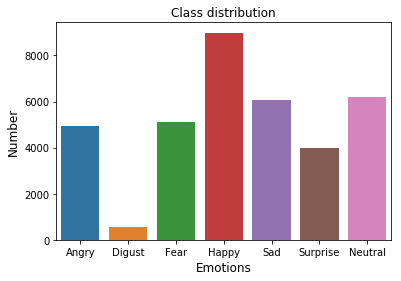

In [14]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

#### Showing some images:

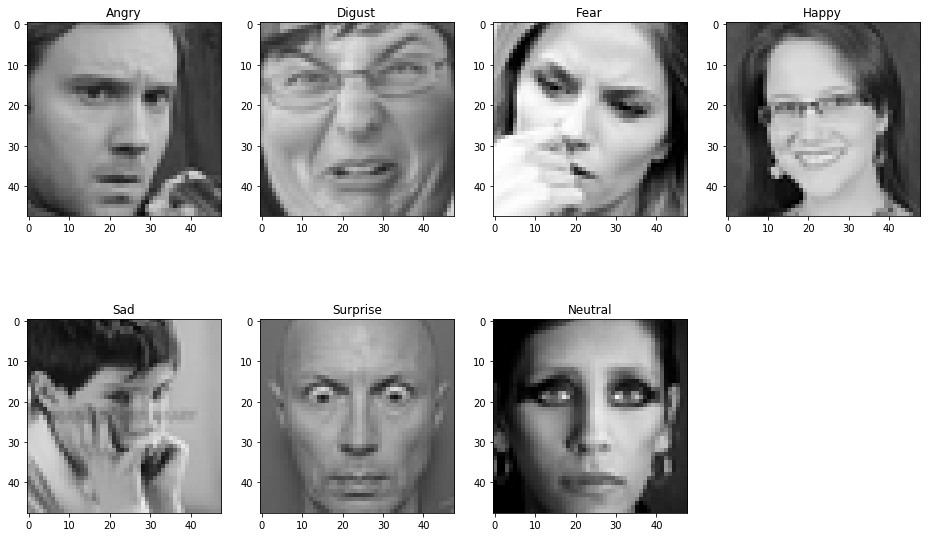

In [15]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

----------------------------------------------------------------------------------
## Pre-processing data

1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [16]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [19]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [20]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


----------------------------------------------------------------------------------
## Building CNN Model

### CNN Architecture:  
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling 
* Flatten
* Dense -> BN -> Activation
* Dense -> BN -> Activation
* Dense -> BN -> Activation
* Output layer

In [21]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)       0         
__________

In [22]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
 - 35s - loss: 1.7087 - acc: 0.3164 - val_loss: 1.6462 - val_acc: 0.3383
Epoch 2/50
 - 29s - loss: 1.4146 - acc: 0.4500 - val_loss: 1.3259 - val_acc: 0.4890
Epoch 3/50
 - 29s - loss: 1.2594 - acc: 0.5189 - val_loss: 1.2471 - val_acc: 0.5222
Epoch 4/50
 - 29s - loss: 1.1810 - acc: 0.5519 - val_loss: 1.1569 - val_acc: 0.5534
Epoch 5/50
 - 29s - loss: 1.1308 - acc: 0.5721 - val_loss: 1.4127 - val_acc: 0.5205
Epoch 6/50
 - 29s - loss: 1.0923 - acc: 0.5867 - val_loss: 1.1747 - val_acc: 0.5528
Epoch 7/50
 - 29s - loss: 1.0584 - acc: 0.5970 - val_loss: 1.1355 - val_acc: 0.5731
Epoch 8/50
 - 29s - loss: 1.0332 - acc: 0.6077 - val_loss: 1.1311 - val_acc: 0.5832
Epoch 9/50
 - 29s - loss: 1.0055 - acc: 0.6198 - val_loss: 1.1927 - val_acc: 0.5564
Epoch 10/50
 - 29s - loss: 0.9877 - acc: 0.6243 - val_loss: 1.1248 - val_acc: 0.5829
Epoch 11/50
 - 29s - loss: 0.9687 - acc: 0.6334 - val_loss: 1.0476 - val_acc: 0.5982
Epoch 12/50
 - 29s - loss: 0.9517 - acc: 0.6383 - val_loss: 1.0692 - val_a

## Visualize Training Performance

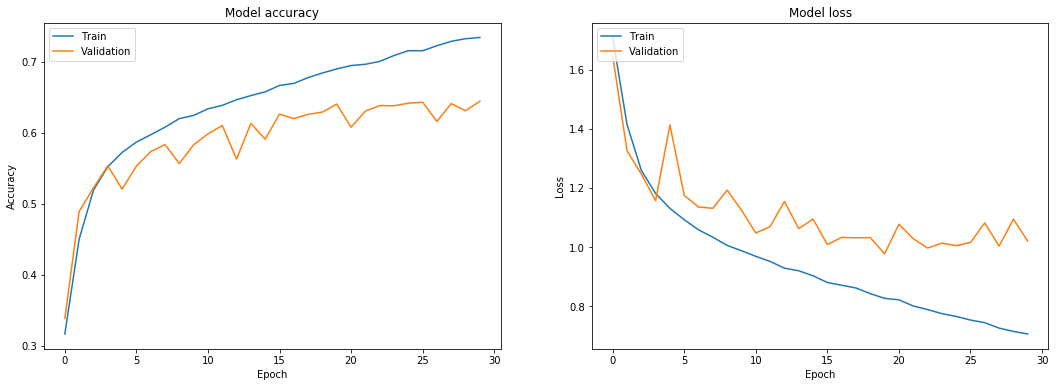

In [23]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['acc'])
axes[0].plot(history.history['val_acc'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate Test Performance

In [24]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6565


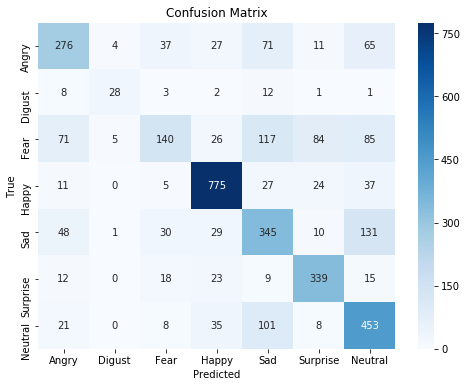

In [25]:
# Evaluate on test set
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)

# Confusion Matrix
cm = confusion_matrix(test_true, test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_map.values(), yticklabels=emotion_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

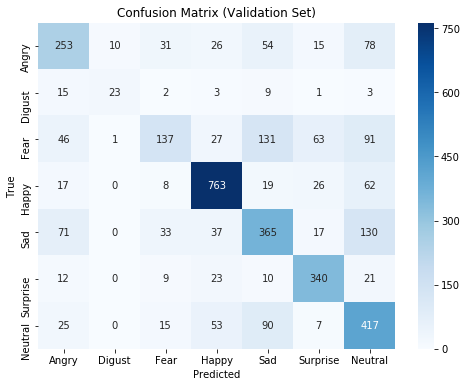

Validation Set Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.54      0.56       467
      Digust       0.68      0.41      0.51        56
        Fear       0.58      0.28      0.37       496
       Happy       0.82      0.85      0.84       895
         Sad       0.54      0.56      0.55       653
    Surprise       0.72      0.82      0.77       415
     Neutral       0.52      0.69      0.59       607

    accuracy                           0.64      3589
   macro avg       0.63      0.59      0.60      3589
weighted avg       0.64      0.64      0.63      3589



In [26]:
# Evaluate on validation set
val_true = np.argmax(val_Y, axis=1)
val_pred = np.argmax(model.predict(val_X), axis=1)

# Confusion Matrix for Validation Set
cm_val = confusion_matrix(val_true, val_pred)

# Plot Confusion Matrix for Validation Set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_map.values(), yticklabels=emotion_map.values())
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report for Validation Set
class_labels = list(emotion_map.values())
report_val = classification_report(val_true, val_pred, target_names=class_labels)

# Printing the classification report for Validation Set
print("Validation Set Classification Report:")
print(report_val)

In [27]:
# Save the trained model
model.save("emotion_model.h5")

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 320ms/step


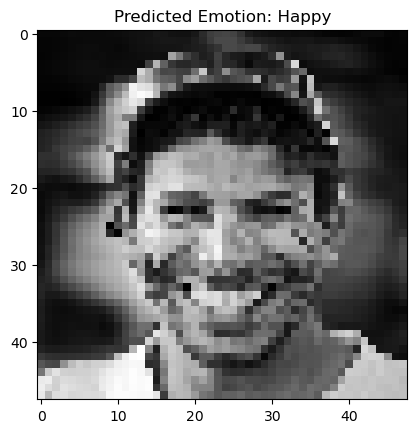

In [1]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('emotion_model.h5')

# Load and preprocess the image
path = "happy.jpeg"
img = load_img(path, target_size=(48, 48), grayscale=True)  # Adjust target_size according to your model input shape

img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make a prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Mapping predicted class index to emotion label
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
predicted_emotion = emotion_labels[predicted_class]

# Display the image and prediction result
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.show()

1/1 [==============================] - 0s 163ms/step


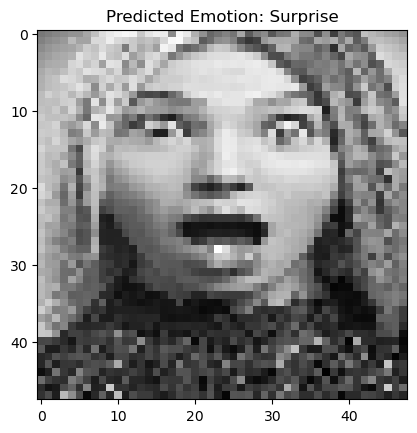

In [3]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('emotion_model.h5')

# Load and preprocess the image
path = "surprised.jpeg"
img = load_img(path, target_size=(48, 48), grayscale=True)  # Adjust target_size according to your model input shape

img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make a prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Mapping predicted class index to emotion label
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
predicted_emotion = emotion_labels[predicted_class]

# Display the image and prediction result
plt.imshow(img, cmap='gray')
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.show()